<a href="https://colab.research.google.com/github/jajapuramshivasai/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [2]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.


Born Rule : 

The Born rule connects the quantum state to measurement outcomes.
For a quantum state represented by a density matrix ρ and a measurement
operator Mₖ, the probability of observing outcome k is

p(k) = Tr(Mₖ ρ).

For projective measurements, Mₖ are orthogonal projectors.
In the more general POVM framework, measurement operators Eₖ are
positive semi-definite and satisfy the completeness condition
∑ₖ Eₖ = I.

This framework allows informationally complete measurements that are
not restricted to orthogonal bases.


In [3]:
import numpy as np

# Identity matrix
I = np.eye(2)

# Pauli-Z projectors
P0 = np.array([[1, 0],
               [0, 0]])
P1 = np.array([[0, 0],
               [0, 1]])

# Completeness check
print("Sum of projectors:")
print(P0 + P1)
print("Is close to identity?", np.allclose(P0 + P1, I))


Sum of projectors:
[[1 0]
 [0 1]]
Is close to identity? True


### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

Pauli projective measurements are simple and hardware-friendly, as they
correspond directly to eigenbases of Pauli operators. However, full
tomography requires measurements in multiple bases, increasing the
number of shots.

SIC POVMs provide informational completeness with fewer outcomes and a
highly symmetric structure, which can improve reconstruction stability.
The downside is increased calibration complexity and more involved
classical post-processing.

In this project, Pauli measurements are adopted for simplicity and
clarity, while the measurement interface is kept general enough to
support SIC POVMs in later extensions.


In [4]:
import numpy as np
from typing import Dict, Any
import pathlib

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Construct Pauli projective measurement operators for a single qubit.
    """
    measurements = {}

    # Z basis
    measurements["Z"] = [
        np.array([[1, 0],
                  [0, 0]]),
        np.array([[0, 0],
                  [0, 1]])
    ]

    # X basis
    measurements["X"] = [
        0.5 * np.array([[1, 1],
                        [1, 1]]),
        0.5 * np.array([[1, -1],
                        [-1, 1]])
    ]

    # Y basis
    measurements["Y"] = [
        0.5 * np.array([[1, -1j],
                        [1j, 1]]),
        0.5 * np.array([[1, 1j],
                        [-1j, 1]])
    ]

    completeness = {
        basis: np.allclose(sum(ops), np.eye(2))
        for basis, ops in measurements.items()
    }

    return {
        "type": "pauli_projective",
        "operators": measurements,
        "completeness": completeness,
        "config_path_used": str(config_path)
    }


In [5]:
model = build_measurement_model(None)

for basis, ops in model["operators"].items():
    print(basis, model["completeness"][basis])


Z True
X True
Y True


### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

We construct a small set of reference single-qubit states that span
different regions of the Bloch sphere. Each state is synthesized from
the computational basis using simple single-qubit gates. Alongside
each density matrix, we store a compact description of the gate
sequence used to prepare the state.


In [6]:
import numpy as np

def reference_single_qubit_states():
    """
    Returns reference single-qubit states along with
    their preparation circuits.
    """
    states = {}

    # |0>
    states["|0>"] = {
        "rho": np.array([[1, 0],
                         [0, 0]]),
        "circuit": ["|0> (initial state)"]
    }

    # |1> = X |0>
    states["|1>"] = {
        "rho": np.array([[0, 0],
                         [0, 1]]),
        "circuit": ["X"]
    }

    # |+> = H |0>
    states["|+>"] = {
        "rho": 0.5 * np.array([[1, 1],
                               [1, 1]]),
        "circuit": ["H"]
    }

    # |-> = H X |0>
    states["|->"] = {
        "rho": 0.5 * np.array([[1, -1],
                               [-1, 1]]),
        "circuit": ["X", "H"]
    }

    # (|0> + i|1>) / √2 = S H |0>
    states["|i>"] = {
        "rho": 0.5 * np.array([[1, -1j],
                               [1j, 1]]),
        "circuit": ["H", "S"]
    }

    return states



In [7]:
states = reference_single_qubit_states()

for name, info in states.items():
    print(name, "prepared by gates:", info["circuit"])


|0> prepared by gates: ['|0> (initial state)']
|1> prepared by gates: ['X']
|+> prepared by gates: ['H']
|-> prepared by gates: ['X', 'H']
|i> prepared by gates: ['H', 'S']


In [8]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [9]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [10]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [11]:
def measurement_probabilities(rho, operators):
    """
    Compute Born rule probabilities for a list of measurement operators.
    """
    probs = []
    for M in operators:
        p = np.real(np.trace(M @ rho))
        probs.append(p)
    return np.array(probs)


In [12]:
def sample_measurements(probs, shots):
    """
    Sample measurement outcomes given probabilities.
    """
    return np.random.multinomial(shots, probs)


In [13]:
from dataclasses import dataclass
from typing import List
import pathlib

@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

import json
import numpy as np

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    measurement_model = build_measurement_model(None)
    reference_states = reference_single_qubit_states()
    shots = 1000

    for variant in variants:
        state_info = reference_states[variant.name]
        rho = state_info["rho"]

        all_counts = {}
        all_probs = {}

        for basis, operators in measurement_model["operators"].items():
            probs = measurement_probabilities(rho, operators)
            counts = sample_measurements(probs, shots)

            all_probs[basis] = probs
            all_counts[basis] = counts

        # Save measurement data
        np.save(
            variant.measurement_data_path,
            {
                "counts": all_counts,
                "probs": all_probs
            }
        )

        # Save ground-truth density matrix
        np.save(variant.density_matrix_path, rho)

        # Save metadata
        metadata = {
            "state": variant.name,
            "circuit": state_info["circuit"],
            "measurement_model": variant.measurement_model,
            "shots": shots,
            "bases": list(measurement_model["operators"].keys())
        }

        with open(variant.metadata_path, "w") as f:
            json.dump(metadata, f, indent=2)


In [14]:
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

variants = []

for state_name in reference_single_qubit_states().keys():
    variants.append(
        DatasetVariant(
            name=state_name,
            circuit_summary="; ".join(reference_single_qubit_states()[state_name]["circuit"]),
            measurement_model="pauli_projective",
            measurement_data_path=data_dir / f"single_qubit_{state_name.replace('|','').replace('>','')}.npy",
            metadata_path=data_dir / f"single_qubit_{state_name.replace('|','').replace('>','')}_meta.json",
            density_matrix_path=data_dir / f"single_qubit_{state_name.replace('|','').replace('>','')}_rho.npy"
        )
    )


In [15]:
generate_measurement_dataset(variants)
print("Dataset generation complete.")


Dataset generation complete.


In [16]:
example = np.load("data/single_qubit_0.npy", allow_pickle=True).item()
print(example)


{'counts': {'Z': array([1000,    0], dtype=int32), 'X': array([474, 526], dtype=int32), 'Y': array([498, 502], dtype=int32)}, 'probs': {'Z': array([1, 0]), 'X': array([0.5, 0.5]), 'Y': array([0.5, 0.5])}}


## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [17]:
import pathlib

base_dir = pathlib.Path("data/single_qubit")
base_dir.mkdir(parents=True, exist_ok=True)


In [18]:
def expectation_from_counts(counts):
    """
    Compute expectation value from two-outcome measurement counts.
    """
    total = np.sum(counts)
    return (counts[0] - counts[1]) / total


In [19]:
def reconstruct_density_matrix_pauli(measurement_counts):
    """
    Reconstruct a single-qubit density matrix using linear inversion.
    """
    sx = expectation_from_counts(measurement_counts["X"])
    sy = expectation_from_counts(measurement_counts["Y"])
    sz = expectation_from_counts(measurement_counts["Z"])

    I = np.eye(2)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    rho = 0.5 * (
        I +
        sx * sigma_x +
        sy * sigma_y +
        sz * sigma_z
    )

    return rho


In [20]:
def fidelity_pure(rho_true, rho_est):
    """
    Fidelity between true and estimated density matrix
    when true state is pure.
    """
    return np.real(np.trace(rho_true @ rho_est))


In [21]:
def bloch_vector_from_rho(rho):
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    return np.array([
        np.real(np.trace(rho @ sigma_x)),
        np.real(np.trace(rho @ sigma_y)),
        np.real(np.trace(rho @ sigma_z))
    ])


In [22]:
def bloch_error(rho_true, rho_est):
    return np.linalg.norm(
        bloch_vector_from_rho(rho_true) -
        bloch_vector_from_rho(rho_est)
    )


In [23]:
import json

results = []

for variant in variants:
    # Load measurement data
    data = np.load(variant.measurement_data_path, allow_pickle=True).item()
    counts = data["counts"]

    # Load true density matrix
    rho_true = np.load(variant.density_matrix_path)

    # Reconstruct
    rho_est = reconstruct_density_matrix_pauli(counts)

    # Metrics
    fid = fidelity_pure(rho_true, rho_est)
    err = bloch_error(rho_true, rho_est)

    # Save reconstructed density matrix
    recon_path = base_dir / f"{variant.name.replace('|','').replace('>','')}_recon.npy"
    np.save(recon_path, rho_est)

    # Store metrics
    result = {
        "state": variant.name,
        "fidelity": float(fid),
        "bloch_error": float(err)
    }
    results.append(result)

    # Save metadata
    meta_path = base_dir / f"{variant.name.replace('|','').replace('>','')}_metrics.json"
    with open(meta_path, "w") as f:
        json.dump(result, f, indent=2)


In [24]:
for r in results:
    print(
        r["state"],
        "fidelity =", round(r["fidelity"], 4),
        "bloch error =", round(r["bloch_error"], 4)
    )


|0> fidelity = 1.0 bloch error = 0.0522
|1> fidelity = 1.0 bloch error = 0.0179
|+> fidelity = 1.0 bloch error = 0.0649
|-> fidelity = 1.0 bloch error = 0.0268
|i> fidelity = 1.0 bloch error = 0.0102


In [25]:
example_state = results[0]["state"]
rho_est = np.load(base_dir / f"{example_state.replace('|','').replace('>','')}_recon.npy")

plot_density_matrix_histogram(
    rho_est,
    basis_labels=["0", "1"],
    title=f"Reconstructed density matrix for {example_state}"
)


## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [26]:
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Placeholder for pulling metrics (fidelity, trace distance, etc.) from stored validation artifacts.
    Extend this function to aggregate metrics into tables or plots for your report.
    """
    # TODO: load metrics, compute aggregates, and emit summaries/plots.
    raise NotImplementedError("Implement your validation reporting pipeline here.")

In [27]:
import json
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Load validation metrics and print a summary table and aggregates.
    """
    records = []

    for path in result_paths:
        with open(path, "r") as f:
            data = json.load(f)
            records.append(data)

    # Print table
    print(f"{'State':>6} | {'Fidelity':>8} | {'Bloch Error':>11}")
    print("-" * 32)
    for r in records:
        print(
            f"{r['state']:>6} | "
            f"{r['fidelity']:.4f} | "
            f"{r['bloch_error']:.4f}"
        )

    # Aggregate statistics
    fidelities = np.array([r["fidelity"] for r in records])
    bloch_errors = np.array([r["bloch_error"] for r in records])

    print("\nAggregate statistics:")
    print("Mean fidelity     :", np.mean(fidelities))
    print("Mean Bloch error  :", np.mean(bloch_errors))
    print("Max Bloch error   :", np.max(bloch_errors))


In [28]:
metrics_dir = Path("data/single_qubit")
metric_files = list(metrics_dir.glob("*_metrics.json"))

summarize_validation_runs(metric_files)


 State | Fidelity | Bloch Error
--------------------------------
   |+> | 1.0000 | 0.0649
   |-> | 1.0000 | 0.0268
   |0> | 1.0000 | 0.0522
   |1> | 1.0000 | 0.0179
   |i> | 1.0000 | 0.0102

Aggregate statistics:
Mean fidelity     : 1.0
Mean Bloch error  : 0.03439458815543088
Max Bloch error   : 0.06489992295835184


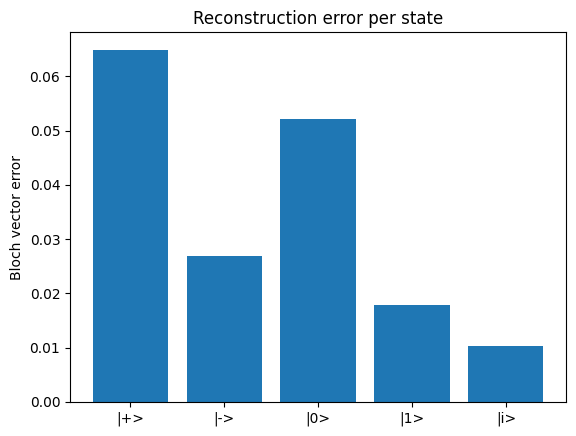

In [29]:
import matplotlib.pyplot as plt

states = []
bloch_errors = []

for path in metric_files:
    with open(path) as f:
        d = json.load(f)
        states.append(d["state"])
        bloch_errors.append(d["bloch_error"])

plt.figure()
plt.bar(states, bloch_errors)
plt.ylabel("Bloch vector error")
plt.title("Reconstruction error per state")
plt.show()


Below we visualize reconstructed density matrices using histogram plots
to qualitatively assess phase coherence and off-diagonal structure.


In [30]:
rho_est = np.load("data/single_qubit/0_recon.npy")

plot_density_matrix_histogram(
    rho_est,
    basis_labels=["0", "1"],
    title="Reconstructed |0⟩ density matrix"
)


### Sources of error and mitigation

The dominant source of reconstruction error is finite-shot noise,
which introduces statistical fluctuations in estimated expectation
values. This effect is visible in small deviations of Bloch vectors
from their ideal values.

Additional sources include:
- Measurement basis misalignment (not modeled here)
- Linear inversion artifacts (non-physical density matrices in noisy regimes)
- Simulator idealizations (no hardware noise)

Potential mitigation strategies include increasing the number of shots,
using maximum-likelihood estimation, or incorporating noise-aware
measurement models.


### Reflection and outlook

This project implemented a complete single-qubit quantum state
tomography pipeline, from synthetic data generation to reconstruction
and validation. The modular structure enabled rapid iteration and
clear separation between physics, simulation, and analysis layers.

Key challenges included managing data serialization and ensuring
numerical stability under finite-shot noise. Future work will explore
multi-qubit tomography, noise-aware reconstruction methods, and
machine-learning-assisted state estimation.


## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----